In [1]:
import jax.numpy as np
import tree_math
import dataclasses

from jaxsnn.base import funcutils
from jaxsnn.base import implicit
from jaxsnn.tree_solver import ArrayLike, tree_solve, tree_matmul


In [2]:
@tree_math.struct
class NeuronState:
    v: ArrayLike
    I: ArrayLike

@dataclasses.dataclass
class MultiCompartmentNeuronModel(implicit.ImplicitExplicitODE):
  d : ArrayLike
  u : ArrayLike
  p : ArrayLike

  def explicit_terms(self, state):
    return NeuronState(
      v = state.I,
      I = -20*state.I
    )

  def implicit_terms(self, state):
    return NeuronState(
      v = tree_matmul(self.d, self.u, self.p, state.v),
      I = np.zeros_like(state.I)
    )

  def implicit_solve(self, state, step_size):
    return NeuronState(
      v = tree_solve(1 - step_size * self.d, -step_size * self.u, self.p, state.v),
      I = state.I
    )

In [3]:
N = 20
dt =1e-2
inner_steps=1
outer_steps=2000
time = dt * inner_steps * (1 + np.arange(outer_steps))


equation = MultiCompartmentNeuronModel(
    d = -2*np.ones(N),
    u = np.ones(N-1),
    p = np.arange(-1,N,1)
)

initial_state = NeuronState(
    v = np.zeros(N),
    I = np.concatenate((np.array([1.0, 0.0, 0.0, 0.0]), np.zeros(N-4)))
)

semi_implicit_step = implicit.crank_nicolson_rk2(equation, dt)
integrator = funcutils.trajectory(
            funcutils.repeated(semi_implicit_step, inner_steps), outer_steps)
_, actual = integrator(initial_state)

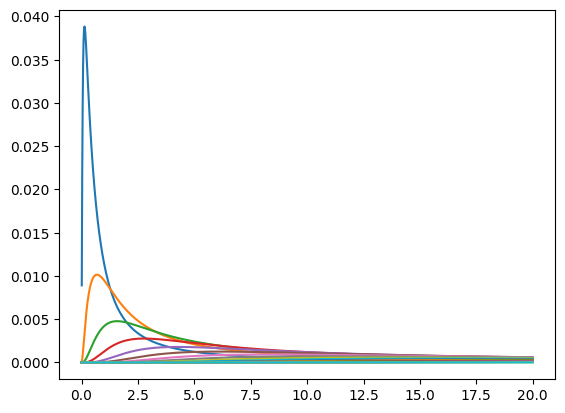

In [4]:
import matplotlib.pyplot as plt

plt.plot(time, actual.v)
plt.show()

In [14]:
a = np.array([
  [0,0,0,0,0,0,0,0],
  [1,0,0,0,0,0,0,0],
  [0,1,0,0,0,0,0,0],
  [0,0,1,0,0,0,0,0],
  [0,0,1,0,0,0,0,0],
  [0,1,0,0,0,0,0,0],
  [0,0,0,0,0,1,0,0],
  [0,0,0,0,0,1,0,0],
])

b = np.arange(1,9)

parents = np.matmul(a, b)

In [21]:
np.diag(np.sum(a + a.T, axis=0)) - (a + a.T)

DeviceArray([[ 1, -1,  0,  0,  0,  0,  0,  0],
             [-1,  3, -1,  0,  0, -1,  0,  0],
             [ 0, -1,  3, -1, -1,  0,  0,  0],
             [ 0,  0, -1,  1,  0,  0,  0,  0],
             [ 0,  0, -1,  0,  1,  0,  0,  0],
             [ 0, -1,  0,  0,  0,  3, -1, -1],
             [ 0,  0,  0,  0,  0, -1,  1,  0],
             [ 0,  0,  0,  0,  0, -1,  0,  1]], dtype=int32)

In [ ]:
def coupling_matrix(G_m, D_s, G_a, A, D_i):
    """"
    Parameters:
        G_m: membrane conductance
        G_a: axial conductance
        D_s: diagonal matrix of compartment surfaces
        D_i: diagonal matrix of inverse volumes
        A  : adjacency matrix
    """
    m = np.matmul(A, D_i) + np.matmul(D_i, A.T)
    M = G_a * (np.diag(np.sum(m)) - m) + G_m * D_s
    return M

Instead of involving the geometry of the neuron (such as the surface and inverse volumes) we can instead use abstract conductances. This simplifies the implementation of the coupling matrix to

In [ ]:
def coupling_matrix(G, G_m):
    """"
    Parameters:
        G   : coupling conductances
        G_m : membrane coupling conductances (typically dynamic)
    """
    m = G + G.T
    laplace = np.diag(np.sum(m, axis=0)) - m
    return laplace + np.diag(G_m)